In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Homework 2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1xOTFH12ejIcv2XhCAKusSYD6N-YChIUI/Homework 2


In [ ]:
model_to_train = 'E'

In [ ]:
name = 'LSTM + SKIP - 18/' + model_to_train

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def build_sequences(data, window_size=200, telescope=9, stride=1):
    """
    Creates time windows for a given time series data.

    Parameters:
    - data: numpy array, shape (n_samples,)
        The time series data.
    - window_size: int
        The size of the window.
    - telescope: int
        The number of timestamps to predict into the future.
    - stride: int, optional (default=1)
        The step size between consecutive windows.

    Returns:
    - X: numpy array, shape (n_windows, window_size)
        The input features (windows of data).
    - y: numpy array, shape (n_windows, telescope)
        The target values corresponding to each window.
    """

    pad = 0
    n_windows = (len(data) - window_size - telescope) // stride + 1

    if n_windows <= 0:
        # Time series is too short for the specified window size and future steps
        # Pad the time series with zeros at the beginning
        data = np.pad(data, (telescope + window_size - len(data), 0), 'constant', constant_values=pad)
        n_windows = 1
    else:
        to_add = stride + telescope + 1
        n_windows += 2
        data = np.pad(data, (to_add, 0), 'constant', constant_values=pad)

    X = np.zeros((n_windows, window_size))
    y = np.zeros((n_windows, telescope))

    j = 0

    for i in range(0, n_windows * stride, stride):
        window = data[i:i+window_size]
        # Check if the window is not composed of all zeros
        if not np.all(window == 0):
            X[j, :] = window
            y[j, :] = data[i+window_size:i+window_size+telescope]
            j +=1

    return X[:j], y[:j]

In [ ]:
def filter_timeseries(data, validity, min_valid_length, max_percentage = 0.1):

    # Initialize an empty DataFrame for removed time series
    removed = 0

    max_len = int(len(data) * max_percentage)
    mask = np.full(len(data), True)

    # Iterate through each row in the input DataFrame
    for index in range(len(data)):
        # Find the start and end of the validity range for the current time series
        start_validity = validity[index][0]
        end_validity = validity[index][1]

        # Calculate the length of the valid range for the current time series
        valid_length = end_validity - start_validity + 1

        # Check if the valid length is greater than or equal to the specified minimum
        if removed < max_len and valid_length <= min_valid_length:
            mask[index] = False
            removed += 1

        if removed >= max_len:
            return np.array(data[mask]), np.array(data[~mask])

    return np.array(data[mask]), np.array(data[~mask])

In [ ]:
def build_train_test_datasets(dataset_by_categories, valid_by_categories, window = 200, telescope = 9 , stride = 10, max_percentage = 0.1):

    X_train = {k : [] for k in dataset_by_categories.keys()}

    y_train = {k : [] for k in dataset_by_categories.keys()}

    X_test = {k : [] for k in dataset_by_categories.keys()}

    y_test = {k : [] for k in dataset_by_categories.keys()}

    for k in dataset_by_categories.keys():

        training, testing = filter_timeseries(dataset_by_categories[k], valid_by_categories[k], 200, max_percentage=max_percentage)

        for i, ts in enumerate(training):
            valid_start, valid_end = valid_by_categories[k][i]

            v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)#, debug=debug)

            X_train[k].append(v)
            y_train[k].append(l)

        X_train[k] = np.expand_dims(np.concatenate(X_train[k]), axis=2)
        y_train[k] = np.expand_dims(np.concatenate(y_train[k]), axis=2)

        if(max_percentage != 0):

            for i, ts in enumerate(testing):
                valid_start, valid_end = valid_by_categories[k][i]

                v, l = build_sequences(ts[valid_start:valid_end, 0], window_size=window, stride=stride, telescope=telescope)#, debug = debug)

                X_test[k].append(v)
                y_test[k].append(l)

            X_test[k] = np.expand_dims(np.concatenate(X_test[k]), axis=2)
            y_test[k] = np.expand_dims(np.concatenate(y_test[k]), axis=2)

    return X_train, y_train, X_test, y_test

In [ ]:
def difference(data, valid_periods, interval=1):
    out = np.zeros_like(data)

    for i in range(len(data)):

        start, end = valid_periods[i]

        ts = data[i][start:end]

        out[i] [start+1:end] = np.diff(ts.T).T

    return out

In [ ]:
def invert_difference(data, diff_data, valid_periods = 'test', telescope=9):

    inverted_data = diff_data.copy()

    if valid_periods != 'test':
        for i in range(len(diff_data)):
            start, end = valid_periods[i]
            inverted_data[i][start:end] = np.expand_dims(np.concatenate(([data[i][start:end][0]], diff_data[i])).cumsum(), axis=1)[start:end]

    else:
        for i in range(len(diff_data)):
            inverted_data[i] = np.expand_dims(np.concatenate((data[i][0], inverted_data[i]), axis = 0).cumsum(), axis=1)[1:, 0]

    return inverted_data


In [ ]:
training_data = np.load('./training_dataset/training_data.npy')
categories = np.load('./training_dataset/categories.npy')
valid_periods = np.load('./training_dataset/valid_periods.npy')

In [ ]:
print("Training data shape: {}".format(training_data.shape))
print("Categories shape: {}".format(categories.shape))
print("Valid periods shape: {}".format(valid_periods.shape))

Training data shape: (48000, 2776)
Categories shape: (48000,)
Valid periods shape: (48000, 2)


In [ ]:
training_df = pd.DataFrame(training_data)
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
valid_periods_df = pd.DataFrame(valid_periods, columns=('start', 'end'))
valid_periods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   start   48000 non-null  int64
 1   end     48000 non-null  int64
dtypes: int64(2)
memory usage: 750.1 KB


In [ ]:
categories_df = pd.DataFrame(categories, columns=('Category',))
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  48000 non-null  object
dtypes: object(1)
memory usage: 375.1+ KB


In [ ]:
# Remove duplicated time series

unique_mask = ~ training_df.duplicated()
training_data = training_data[unique_mask]
valid_periods = valid_periods[unique_mask]
categories = categories[unique_mask]

training_data_df = pd.DataFrame(training_data)
valid_periods_df = pd.DataFrame(valid_periods, columns=("start", "end"))
categories_df = pd.DataFrame(categories, columns=("Category",))

In [ ]:
dataset_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    dataset_by_categories[category] = np.array(training_data[categories == category])
    dataset_by_categories[category] = np.expand_dims(dataset_by_categories[category], axis=2)

valid_by_categories = {
    'A' : [],
    'B' : [],
    'C' : [],
    'D' : [],
    'E' : [],
    'F' : [],
}

for category in np.unique(categories):
    valid_by_categories[category] = np.array(valid_periods[categories == category])

In [ ]:
valid_periods_df['range'] = valid_periods_df["end"] - valid_periods_df["start"]

print("Minimum Time series length: {}".format(valid_periods_df['range'].min()))
print("Maximum Time series length: {}".format(valid_periods_df['range'].max()))

Minimum Time series length: 24
Maximum Time series length: 2776


In [ ]:
min_range_by_category = {}

for k in dataset_by_categories.keys():
    print(k)
    print("max range : {}".format(valid_periods_df[categories == k]["range"].max()))
    min_range_by_category[k] = valid_periods_df[categories == k]["range"].min()
    print("min range : {}".format(min_range_by_category[k]))
    print("mean range : {}".format(valid_periods_df[categories == k]["range"].mean()))

A
max range : 1943
min range : 46
mean range : 278.18034217877096
B
max range : 1484
min range : 42
mean range : 166.02269413051403
C
max range : 2708
min range : 42
mean range : 208.1937062937063
D
max range : 2641
min range : 42
mean range : 216.99860195725984
E
max range : 2776
min range : 42
mean range : 163.05896290895836
F
max range : 1068
min range : 24
mean range : 194.8303249097473


In [ ]:
test_size = 20
window = 200
stride = 5
telescope = 9

In [ ]:
X_train, y_train, X_test, y_test = build_train_test_datasets(dataset_by_categories = dataset_by_categories,
                                                             valid_by_categories = valid_by_categories,
                                                             window=window,
                                                             telescope=telescope,
                                                             stride=stride,
                                                             max_percentage=0.1)

In [ ]:
def build_model(input_shape, output_shape):

    lstm_n = 64

    input_layer = tfkl.Input(shape=(input_shape))
    input_layer = tfkl.Masking(mask_value=0)(input_layer) # serve mettere 1.1 come padding

    print(input_layer)

    a = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(a) # main1

    b = tfkl.Add()([a,x]) # main1 + skip1

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=True))(b) # main2

    c = tfkl.Add()([b,x]) # main2 + skip2

    x = tfkl.Bidirectional(tfkl.LSTM(lstm_n, return_sequences=False))(c)

    x = tfkl.Flatten()(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Dense(output_shape[0], activation = 'relu', name='output_layer')(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam())

    return model

In [ ]:
input_shape = X_train[model_to_train].shape[1:]
output_shape = y_train[model_to_train].shape[1:]
batch_size = 1024
epochs = 200

callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=25, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.9, min_lr=1e-5)
]

In [ ]:
model = build_model(input_shape, output_shape)#, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 1), dtype=tf.float32, name=None), name='masking/mul:0', description="created by layer 'masking'")
Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 1)]             0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 200, 128)             33792     ['input_2[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 200, 128)             98816     ['bidirectional[1][0]']       
 onal)                            

In [ ]:
# Train the model
model.train_data = X_train[model_to_train]

history = model.fit(
    x = X_train[model_to_train],
    y = y_train[model_to_train],
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = callbacks
).history

Epoch 1/200
80/80 [==============================] - 37s 299ms/step - loss: 0.1387 - val_loss: 0.1224 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 20s 256ms/step - loss: 0.0822 - val_loss: 0.1177 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 22s 271ms/step - loss: 0.0803 - val_loss: 0.1082 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 22s 271ms/step - loss: 0.0812 - val_loss: 0.1183 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 22s 274ms/step - loss: 0.0791 - val_loss: 0.1133 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 22s 275ms/step - loss: 0.0780 - val_loss: 0.1053 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 22s 274ms/step - loss: 0.0771 - val_loss: 0.1157 - lr: 0.0010
Epoch 8/200
80/80 [==============================] - 22s 274ms/step - loss: 0.0766 - val_loss: 0.1147 - lr: 0.0010
Epoch 9/200
80/80 [==============================] - 22s 274ms/step - loss: 0.07

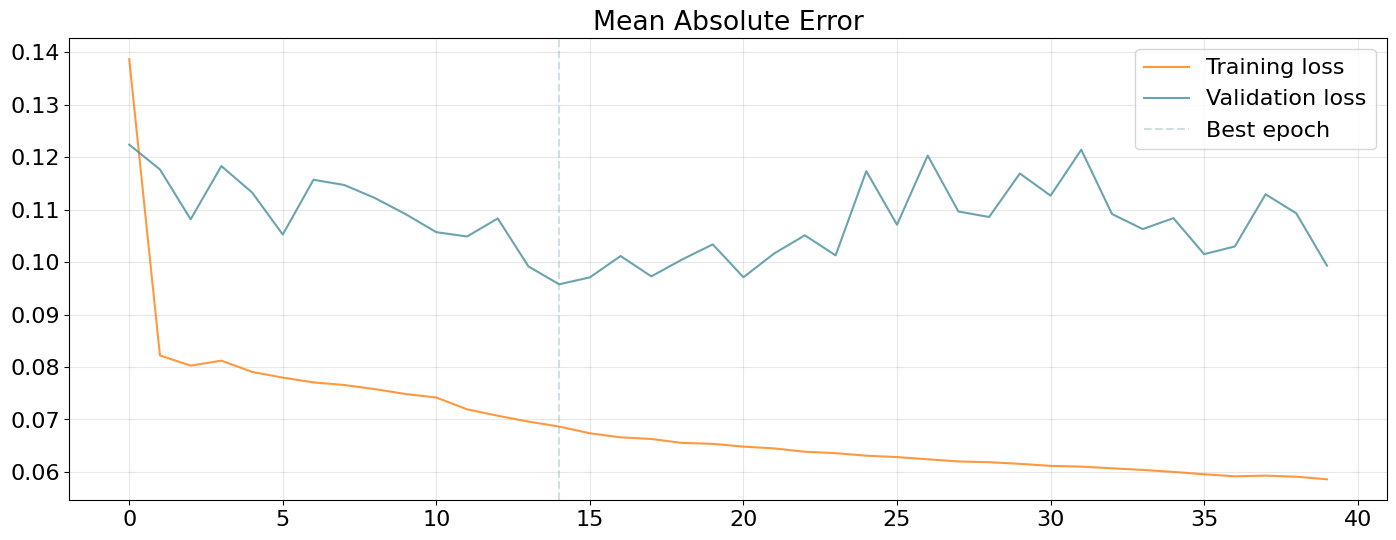

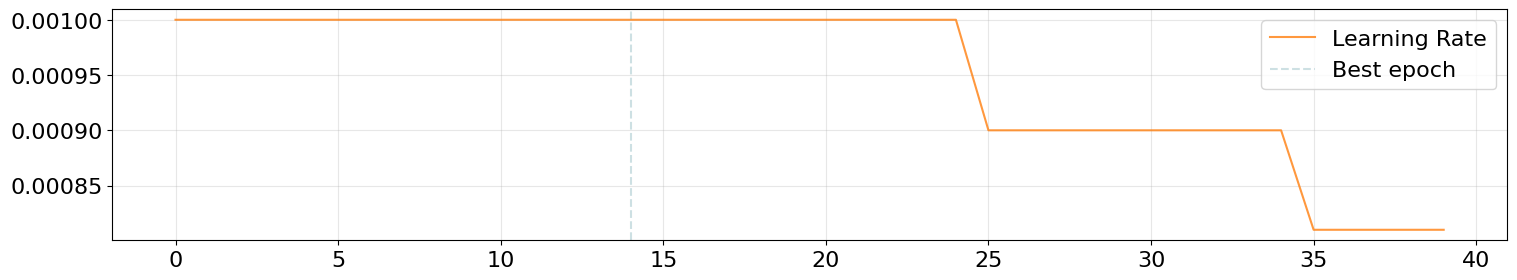

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,6))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test[model_to_train], verbose=0)
#predictions = predictions[:,:,0]

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
# MSE gives more weight to large errors due to squaring.
# It is useful when you want to penalize larger errors more heavily.
mean_squared_error = tfk.metrics.mean_squared_error(y_test[model_to_train].flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
# MAE treats all errors equally, without giving extra weight to larger errors.
# It is useful when you want a metric that is less sensitive to outliers.
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test[model_to_train].flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
def inspect_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    pred = np.concatenate([X[:,-1],pred],axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1],axis=1),y],axis=1)

    len_samples = len(X[0,:])

    plt.figure(figsize=(12,5))
    plt.axvline(x=len_samples-1, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.plot(np.arange(len_samples), X[idx,:], label = 'Given')
    plt.plot(np.arange(len_samples - 1, len_samples + telescope), y[idx,:], color='orange', label = 'Real')
    plt.plot(np.arange(len_samples - 1, len_samples + telescope), pred[idx,:], color='green', label = 'Predicted')
    plt.legend()
    plt.show()

In [ ]:
inspect_prediction(X_test[model_to_train], y_test[model_to_train], predictions, telescope=9)

In [ ]:
model.save("./Models/" + name)